# Unit Testing of Phosphosite-Mapping Module

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import random
from scipy.stats import pearsonr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotnine as p9
from IPython.display import display, clear_output

y_data = pd.read_csv(os.path.join('data', 'synthetic_data_y_scaled.csv'), sep=',', low_memory=False, index_col=0)
y_protein = pd.read_csv(os.path.join('data', 'synthetic_data_y_protein.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)
net = pd.read_csv('data/KEGGnet-Model.tsv', sep = '\t', index_col = False)

Y_in = torch.tensor(y_protein.values, dtype=torch.float32)
Y_actual = torch.tensor(y_data.values, dtype=torch.float32)

print(Y_in.shape, Y_actual.shape)

torch.Size([384, 328]) torch.Size([384, 1057])


## Set-up Time-Mapping Module

`NodesSitesMapping` copy-pasted from 'bionetwork.py'.

`CumsumMapping` copy-pasted from 'bionetwork.py' and `soft_index` copy-pasted from 'train.py'. `add_hooks` is a helper function to add hooks to a model in order to visualize the gradients of the model. 

In [2]:
'''class NodesSitesMapping(nn.Module):
    """Layer to map signaling nodes to phosphosites with sparse connectivity.
       The connectivity is defined by nodes_sites_map, a binary (0/1) DataFrame of shape (n_sites, n_nodes).
       Only the connections indicated by 1 are learnable; we store these as a 1D parameter vector.
    """
    def __init__(self, nodes_sites_map: pd.DataFrame, hidden_layers: dict = None, dtype: torch.dtype = torch.float32, device: str = 'cpu', use_phospho: bool = True):
        """
        Parameters
        ----------
        nodes_sites_map : pd.DataFrame
            DataFrame with sites as rows and signaling nodes as columns.
            It must be one-hot (or sparse instead of dense) where 1 indicates a connection.
        dtype : torch.dtype, optional
            Data type for tensors.
        device : str, optional
            "cpu" or "cuda", by default "cpu".
        use_phospho : bool, optional
            Whether to use the phospho-specific weights, by default True.
        """
        super().__init__()
        self.device = device
        self.dtype = dtype

        # Convert mapping to a tensor and create the boolean mask
        mapping_tensor = torch.tensor(nodes_sites_map.values, dtype=self.dtype, device=self.device)
        self.mask = mapping_tensor != 0  # True where connection exists; shape: (n_sites, n_nodes)
        
        input_dim = nodes_sites_map.shape[1]  # Number of nodes
        output_dim = nodes_sites_map.shape[0]  # Number of sites

        layers = []
        prev_dim = input_dim
        
        # Add hidden layers if specified - Not used
        if hidden_layers:
            for i in range(1, len(hidden_layers) + 1):
                layers.append(nn.Linear(prev_dim, hidden_layers[i]).to(device, dtype))
                layers.append(nn.ReLU())
                prev_dim = hidden_layers[i]
        
        # Learnable parameter vector for the allowed weights (nonzero in the mask) and a bias parameter for each output
        n_nonzero = int(self.mask.sum().item())
        # Save the indices (row, col) where the mapping is 1
        self.indices = self.mask.nonzero(as_tuple=False)  # shape: (n_nonzero, 2)
        
        # Create a learnable vector for allowed connections
        if use_phospho:
            self.real_weights = nn.Parameter(torch.randn(n_nonzero, dtype=self.dtype, device=self.device)+1)
            self.bias = nn.Parameter(torch.zeros(output_dim, dtype=self.dtype, device=self.device))
        else:
            # Register as a buffer so it’s not trainable; it will remain ones
            self.register_buffer('real_weights', torch.ones(n_nonzero, dtype=self.dtype, device=self.device))
            self.register_buffer('bias', torch.zeros(output_dim, dtype=self.dtype, device=self.device))
        
        self.output_dim = output_dim

    def forward(self, Y_full: torch.Tensor):
        """
        Forward pass to map signaling nodes to phosphosites.
    
        Parameters
        ----------
        Y_full : torch.Tensor
            The signaling network output tensor. Shape (samples, time_points, n_nodes).
    
        Returns
        -------
        Y_mapped : torch.Tensor
            The mapped output tensor. Shape (samples, time_points, n_sites).
        """
        samples, time_points, nodes = Y_full.shape
        
        Y_full_reshaped = Y_full.view(samples * time_points, nodes)
        
        # Create a full weight matrix of shape (output_dim, n_nodes) filled with zeros
        full_weight = torch.zeros((self.output_dim, nodes), dtype=self.dtype, device=self.device)
        # Fill the allowed entries with the learnable weights
        full_weight[self.indices[:, 0], self.indices[:, 1]] = self.real_weights
        self.full_weight = full_weight
        Y_mapped_reshaped = torch.nn.functional.linear(Y_full_reshaped, full_weight, self.bias)
        Y_mapped = Y_mapped_reshaped.view(samples, time_points, -1)
        
        return Y_mapped'''

'class NodesSitesMapping(nn.Module):\n    """Layer to map signaling nodes to phosphosites with sparse connectivity.\n       The connectivity is defined by nodes_sites_map, a binary (0/1) DataFrame of shape (n_sites, n_nodes).\n       Only the connections indicated by 1 are learnable; we store these as a 1D parameter vector.\n    """\n    def __init__(self, nodes_sites_map: pd.DataFrame, hidden_layers: dict = None, dtype: torch.dtype = torch.float32, device: str = \'cpu\', use_phospho: bool = True):\n        """\n        Parameters\n        ----------\n        nodes_sites_map : pd.DataFrame\n            DataFrame with sites as rows and signaling nodes as columns.\n            It must be one-hot (or sparse instead of dense) where 1 indicates a connection.\n        dtype : torch.dtype, optional\n            Data type for tensors.\n        device : str, optional\n            "cpu" or "cuda", by default "cpu".\n        use_phospho : bool, optional\n            Whether to use the phospho-spe

In [3]:
class NodesSitesMapping_embedding(nn.Module):
    """
     Alternative mapping layer that converts node-level outputs to phosphosite outputs.
    It first aggregates node outputs to site-level via a one-hot mapping (nodes_sites_map).
    Then, for each site, concatenates the aggregated scalar with a learned site embedding,
    and feeds the combined vector through an MLP to produce the final output.
    
    Input:
         Y_full: torch.Tensor of shape (samples, time_points, n_nodes)
    Output:
         Y_mapped: torch.Tensor of shape (samples, time_points, n_sites)
    """
    def __init__(self, nodes_sites_map: pd.DataFrame, conn_dim: int = 10,
                 hidden_layers: dict = None,
                 dtype: torch.dtype = torch.float32, device: str = 'cpu', use_phospho: bool = True):
        super().__init__()
        self.device = device
        self.dtype = dtype
        self.conn_dim = conn_dim

        self.n_sites = nodes_sites_map.shape[0]  # number of phosphosites
        self.n_nodes = nodes_sites_map.shape[1]  # number of signaling nodes
        
        self.mapping_tensor = torch.tensor(nodes_sites_map.values, dtype=self.dtype, device=self.device)

        # Create node embedding (nodes x conn_dim)
        self.site_embedding = nn.Parameter(torch.randn(self.n_sites, conn_dim, dtype=self.dtype, device=self.device))
        torch.nn.init.orthogonal_(self.site_embedding)  # Initialize with orthogonal matrix

        self.emb_bias = nn.Parameter(torch.zeros(self.n_sites, dtype=self.dtype, device=self.device))
        
        # Construct an MLP that maps from conn_dim to 1
        mlp_input_dim = conn_dim
        layers = []
        if hidden_layers:
            input_dim = mlp_input_dim
            for key in sorted(hidden_layers.keys()):
                layers.append(nn.Linear(input_dim, hidden_layers[key], bias=True))
                layers.append(nn.ReLU())
                input_dim = hidden_layers[key]
            # Final layer outputs one scalar per site.
            layers.append(nn.Linear(input_dim, 1, bias=True))
        else:
            layers.append(nn.Linear(mlp_input_dim, 1, bias=True))
        
        self.non_linear = nn.Sequential(*layers).to(device, dtype)
        
    def forward(self, Y_full: torch.Tensor):
        """
        Forward pass.
        
        Parameters
        ----------
        Y_full : torch.Tensor
            Node-level outputs (samples, time_points, n_nodes)
        
        Returns
        -------
        Y_mapped : torch.Tensor
            Phosphosite outputs (samples, time_points, n_sites)
        """
        samples, time_points, _ = Y_full.shape
        
        B = samples * time_points
        
        site_agg = torch.matmul(Y_full, self.mapping_tensor.t())  # (samples, time_points, n_sites)
        site_agg_unsq = site_agg.unsqueeze(-1)  # (samples, time_points, n_sites, 1)
        emb_exp = self.site_embedding.unsqueeze(0).unsqueeze(0).expand(samples, time_points, self.n_sites, self.conn_dim)
        mlp_input = emb_exp * site_agg_unsq 
        
        # Add the bias term for each site
        emb_bias = self.emb_bias.unsqueeze(0).unsqueeze(0).expand(samples, time_points, self.n_sites).unsqueeze(-1)  # (samples, time_points, n_sites, 1)
        mlp_input = mlp_input + emb_bias  # (samples, time_points, n_sites, 1)
        
        B = samples * time_points * self.n_sites
        mlp_input_flat = mlp_input.view(B, -1)  # (B, 1 + conn_dim)
        mlp_output_flat = self.non_linear(mlp_input_flat)  # (B, 1)
        Y_mapped = mlp_output_flat.view(samples, time_points, self.n_sites)
        
        return Y_mapped

In [4]:
class CumsumMapping(nn.Module):
    def __init__(self, bionet_params: dict, K: int = 8):
        """
        Parameter
        ----------
        bionet_params : Dict[str, float]
            training parameters for the model, by default None
            Key values include:
                - 'max_steps': maximum number of time steps of the RNN, by default 300
                - 'tolerance': threshold at which to break RNN; based on magnitude of change of updated edge weight values, by default 1e-5
                - 'leak': parameter to tune extent of leaking, analogous to leaky ReLU, by default 0.01
                - 'spectral_target': _description_, by default np.exp(np.log(params['tolerance'])/params['target_steps'])
                - 'exp_factor': _description_, by default 20
        K : Int
            Number of training time points
        """
        super().__init__()
        self.L = bionet_params['max_steps']
        self.K = K
        
        # Initialize K raw parameters for increments.
        # We set the first element to a very low value (e.g., -3) so that softplus gives a small number,
        # and initialize the others to a constant so that softplus outputs ~1.
        self.delta_raw = nn.Parameter(torch.empty(K))
        nn.init.constant_(self.delta_raw, 0.541)  # so softplus(0.541) ≈ 1.0
        with torch.no_grad():
            self.delta_raw[0] = -3.0  # so softplus(-3.0) ≈ 0.05
        
        # Learnable parameter for the upper bound.
        # We want u to lie in (0, L), so we use a sigmoid scaling.
        self.u_raw = nn.Parameter(torch.tensor(0.0))  # initial u ~ L * sigmoid(0)=L/2
        
        # Learnable nonlinearity parameter alpha.
        # Initialize to a negative value to bias more anchors toward the beginning.
        self.alpha = nn.Parameter(torch.tensor(-1.0))
    
    def forward(self):
        """
        Returns
        -------
        mapping : torch.Tensor of shape (K,)
            Continuous mapping indices that lie in [0, u],
            where u is learnable and u < L.
        """
        L = self.L
        
        # Compute learnable upper bound u in (0, L)
        u = L * torch.sigmoid(self.u_raw)
        
        # Compute raw anchors from delta_raw:
        deltas = F.softplus(self.delta_raw)   # ensure positive increments
        anchors = torch.cumsum(deltas, dim=0)   # monotonic increasing
        # Shift so the first anchor is zero:
        anchors_shifted = anchors - anchors[0]
        
        # Normalize anchors to [0,1]:
        normalized = anchors_shifted / (anchors_shifted[-1] + 1e-8)
        
        # Apply a nonlinear mapping function:
        # mapping(x) = u * (exp(alpha*x) - 1) / (exp(alpha) - 1)
        # If alpha is near zero, fall back to linear mapping.
        eps = 1e-6
        if torch.abs(self.alpha) < eps:
            mapping = u * normalized
        else:
            mapping = u * (torch.exp(self.alpha * normalized) - 1) / (torch.exp(self.alpha) - 1)
        
        # Enforce that the mapping values are less than L.
        mapping = torch.clamp(mapping, 0, L - 1)
        return mapping


def soft_index(Y: torch.Tensor, indices: torch.Tensor):
    """
    Differentiably sample hidden states from Y using linear interpolation.
    
    Parameters
    ----------
    Y : torch.Tensor
        Tensor of shape (batch, L, feat) (here, L is the number of time points).
    indices : torch.Tensor
        Continuous mapping indices of shape (K,) in [0, L-1].
    
    Returns
    -------
    Y_selected : torch.Tensor
        Tensor of shape (batch, K, feat) with the interpolated values.
    time_idx : torch.Tensor
        Approximate (rounded) indices for monitoring.
    """
    batch, L, feat = Y.shape
    K = indices.shape[0]
    floor_idx = torch.floor(indices).long()       # shape (K,)
    ceil_idx = torch.clamp(floor_idx + 1, max=L - 1)  # shape (K,)
    weight = (indices - floor_idx.float()).view(1, -1, 1)  # shape (1, K, 1)
    
    floor_idx_full = floor_idx.view(1, -1, 1).expand(batch, -1, feat)
    ceil_idx_full = ceil_idx.view(1, -1, 1).expand(batch, -1, feat)
    
    Y_floor = torch.gather(Y, 1, floor_idx_full)
    Y_ceil = torch.gather(Y, 1, ceil_idx_full)
    
    Y_selected = (1 - weight) * Y_floor + weight * Y_ceil
    time_idx = torch.round((floor_idx + ceil_idx) / 2)
    return Y_selected, time_idx


def add_hooks(module):
    gradients = {}

    def hook_fn(grad, name):
        gradients[name] = grad

    for name, param in module.named_parameters():
        param.register_hook(lambda grad, name=name: hook_fn(grad, name))

    return gradients

## Create test cases

1. Just predict the full time series.

In [5]:
'''def split_data(Y_in, Y_tgt, train_fraction=0.8):
    n_samples = Y_in.shape[0]
    n_train = int(n_samples * train_fraction)
    Y_in_train = Y_in[:n_train]
    Y_tgt_train = Y_tgt[:n_train]
    Y_in_test  = Y_in[n_train:]
    Y_tgt_test = Y_tgt[n_train:]
    return Y_in_train, Y_tgt_train, Y_in_test, Y_tgt_test

def train_phospho_mapping(mapping_module, Y_input_train, Y_target_train, Y_input_test, Y_target_test, num_epochs=1000, lr=1e-3, print_freq=100):
    """
    Train the mapping module to predict Y_target (Y_fullFull) from Y_input (Y_fullprotein).
    
    Parameters:
       mapping_module: instance of the mapping module.
       Y_input_train: Tensor of training input (e.g., Y_fullprotein) with shape (samples_train, time_points, n_nodes)
       Y_target_train: Tensor of training target (e.g., Y_fullFull) with shape (samples_train, time_points, n_sites)
       Y_input_test: Tensor of test input with shape (samples_test, time_points, n_nodes)
       Y_target_test: Tensor of test target with shape (samples_test, time_points, n_sites)
       num_epochs: number of epochs to train.
       lr: learning rate.
       print_freq: frequency (in epochs) at which to print and update the loss plot.
       
    Returns:
       mapping_module: the trained model
       final_loss: the final loss value
    """
    device = mapping_module.device
    Y_input_train = Y_input_train.to(device)
    Y_target_train = Y_target_train.to(device)
    Y_input_test = Y_input_test.to(device)
    Y_target_test = Y_target_test.to(device)
    
    optimizer = torch.optim.Adam(mapping_module.parameters(), lr=lr)
    loss_history_list = []
    
    mask = ~torch.isnan(Y_target_train)
    mask_test = ~torch.isnan(Y_target_test)
    
    for epoch in range(num_epochs):
        mapping_module.train()
        optimizer.zero_grad()
            
        # Forward pass: compute predictions from the input Y_fullprotein
        Y_pred = mapping_module(Y_input_train)
        
        train_loss = torch.nn.functional.mse_loss(
            Y_pred.masked_fill(~mask, 0.0),
            Y_target_train.masked_fill(~mask, 0.0)
        )
        train_loss.backward()
        optimizer.step()
        
        # Record training loss
        loss_history_list.append({"epoch": epoch, "loss": train_loss.item(), "set": "Train"})
        
        if epoch % print_freq == 0:
            mapping_module.eval()
            with torch.no_grad():
                Y_test_pred = mapping_module(Y_input_test)
                test_loss = torch.nn.functional.mse_loss(
                    Y_test_pred.masked_fill(~mask_test, 0.0),
                    Y_target_test.masked_fill(~mask_test, 0.0)
                )
            loss_history_list.append({"epoch": epoch, "loss": test_loss.item(), "set": "Test"})
            
            loss_df = pd.DataFrame(loss_history_list)
            p_loss = (p9.ggplot(loss_df, p9.aes(x="epoch", y="loss", color="set"))
                      + p9.geom_line()
                      + p9.labs(x="Epoch", y="MSE Loss", title="Training and Test Loss")
                      + p9.scale_y_log10()
                      + p9.theme_bw()
                      + p9.theme(figure_size=(8, 5)))
            clear_output(wait=True)
            display(p_loss)
    
    return mapping_module, train_loss

Y_actual_reshaped = Y_actual.view(8, 48, -1)
Y_actual_reshaped = Y_actual_reshaped.permute(1, 0, 2).contiguous()
Y_in_reshaped = Y_in.view(8, 48, -1)
Y_in_reshaped = Y_in_reshaped.permute(1, 0, 2).contiguous()

Y_in_train, Y_tgt_train, Y_in_test, Y_tgt_test = split_data(Y_in_reshaped, Y_actual_reshaped, train_fraction=0.8)

#mapping_module = NodesSitesMapping(nodes_sites_map, hidden_layers=None, device='cpu')
mapping_module = NodesSitesMapping_embedding(nodes_sites_map, conn_dim=10, hidden_layers={1: 64}, device='cpu')
trained_module, final_train_loss = train_phospho_mapping(mapping_module, Y_in_train, Y_tgt_train, Y_in_test, Y_tgt_test, num_epochs=2000, lr=1e-2, print_freq=100)
print(Y_in_train.shape, Y_tgt_train.shape, Y_in_test.shape, Y_tgt_test.shape)'''

'def split_data(Y_in, Y_tgt, train_fraction=0.8):\n    n_samples = Y_in.shape[0]\n    n_train = int(n_samples * train_fraction)\n    Y_in_train = Y_in[:n_train]\n    Y_tgt_train = Y_tgt[:n_train]\n    Y_in_test  = Y_in[n_train:]\n    Y_tgt_test = Y_tgt[n_train:]\n    return Y_in_train, Y_tgt_train, Y_in_test, Y_tgt_test\n\ndef train_phospho_mapping(mapping_module, Y_input_train, Y_target_train, Y_input_test, Y_target_test, num_epochs=1000, lr=1e-3, print_freq=100):\n    """\n    Train the mapping module to predict Y_target (Y_fullFull) from Y_input (Y_fullprotein).\n    \n    Parameters:\n       mapping_module: instance of the mapping module.\n       Y_input_train: Tensor of training input (e.g., Y_fullprotein) with shape (samples_train, time_points, n_nodes)\n       Y_target_train: Tensor of training target (e.g., Y_fullFull) with shape (samples_train, time_points, n_sites)\n       Y_input_test: Tensor of test input with shape (samples_test, time_points, n_nodes)\n       Y_target_test

In [6]:
'''weights = mapping_module.real_weights.detach().cpu().numpy()  # (n_nonzero,)
df_weights = pd.DataFrame({"weights": weights})

p_hist = (p9.ggplot(df_weights, p9.aes(x="weights"))
          + p9.geom_histogram(bins=50, fill="#1E90FF", color="black", alpha=0.7)
          + p9.labs(x="Learnable Weights", y="Count")
          + p9.theme_bw()
          + p9.theme(figure_size=(6,4)))
p_hist.show()

bias_df = mapping_module.bias.detach().cpu().numpy()  # (n_nonzero,)
bias_df = pd.DataFrame({"bias": bias_df})

p_hist_b = (p9.ggplot(bias_df, p9.aes(x="bias"))
          + p9.geom_histogram(bins=50, fill="#1E90FF", color="black", alpha=0.7)
          + p9.labs(x="Learnable Bias", y="Count")
          + p9.theme_bw()
          + p9.theme(figure_size=(6,4)))
p_hist_b.show()'''

'''device = mapping_module.device
Y_input = Y_in_test.to(device)

Y_pred = mapping_module(Y_input)
Y_pred = Y_pred - Y_pred[0:1, :, :]
Y_tgt_test = Y_tgt_test - Y_tgt_test[0:1, :, :]

mask_eval = ~torch.isnan(Y_tgt_test)

Y_pred_masked = Y_pred.masked_fill(~mask_eval, 0.0)
Y_tgt_test_masked = Y_tgt_test.masked_fill(~mask_eval, 0.0)

pred_np = Y_pred_masked.detach().cpu().numpy().flatten()
actual_np = Y_tgt_test_masked.detach().cpu().numpy().flatten()

df_corr = pd.DataFrame({"Predicted": pred_np, "Actual": actual_np})

# Compute Pearson correlation coefficient:
pr, _ = pearsonr(df_corr["Predicted"], df_corr["Actual"])
min_val = min(df_corr["Predicted"].min(), df_corr["Actual"].min())
max_val = max(df_corr["Predicted"].max(), df_corr["Actual"].max())

# Create data for the diagonal line:
line_df = pd.DataFrame({"x": [min_val, max_val], "y": [min_val, max_val]})

p_corr = (p9.ggplot(df_corr, p9.aes(x="Predicted", y="Actual"))
          + p9.geom_point(color="#1E90FF", alpha=0.1)
          + p9.geom_line(data=line_df, mapping=p9.aes(x="x", y="y"), color="black")
          + p9.labs(x="Predicted", y="Actual", title=f"Correlation Plot: Pearson r = {pr:.2f}")
          + p9.theme_bw()
          + p9.theme(figure_size=(8,5)))
p_corr.show()'''

'device = mapping_module.device\nY_input = Y_in_test.to(device)\n\nY_pred = mapping_module(Y_input)\nY_pred = Y_pred - Y_pred[0:1, :, :]\nY_tgt_test = Y_tgt_test - Y_tgt_test[0:1, :, :]\n\nmask_eval = ~torch.isnan(Y_tgt_test)\n\nY_pred_masked = Y_pred.masked_fill(~mask_eval, 0.0)\nY_tgt_test_masked = Y_tgt_test.masked_fill(~mask_eval, 0.0)\n\npred_np = Y_pred_masked.detach().cpu().numpy().flatten()\nactual_np = Y_tgt_test_masked.detach().cpu().numpy().flatten()\n\ndf_corr = pd.DataFrame({"Predicted": pred_np, "Actual": actual_np})\n\n# Compute Pearson correlation coefficient:\npr, _ = pearsonr(df_corr["Predicted"], df_corr["Actual"])\nmin_val = min(df_corr["Predicted"].min(), df_corr["Actual"].min())\nmax_val = max(df_corr["Predicted"].max(), df_corr["Actual"].max())\n\n# Create data for the diagonal line:\nline_df = pd.DataFrame({"x": [min_val, max_val], "y": [min_val, max_val]})\n\np_corr = (p9.ggplot(df_corr, p9.aes(x="Predicted", y="Actual"))\n          + p9.geom_point(color="#1E90

2. Predict synthetic data from different functions.

C:\Users\kanto\AppData\Local\Temp\ipykernel_29704\3870311747.py:191: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\themes\themeable.py:2419: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


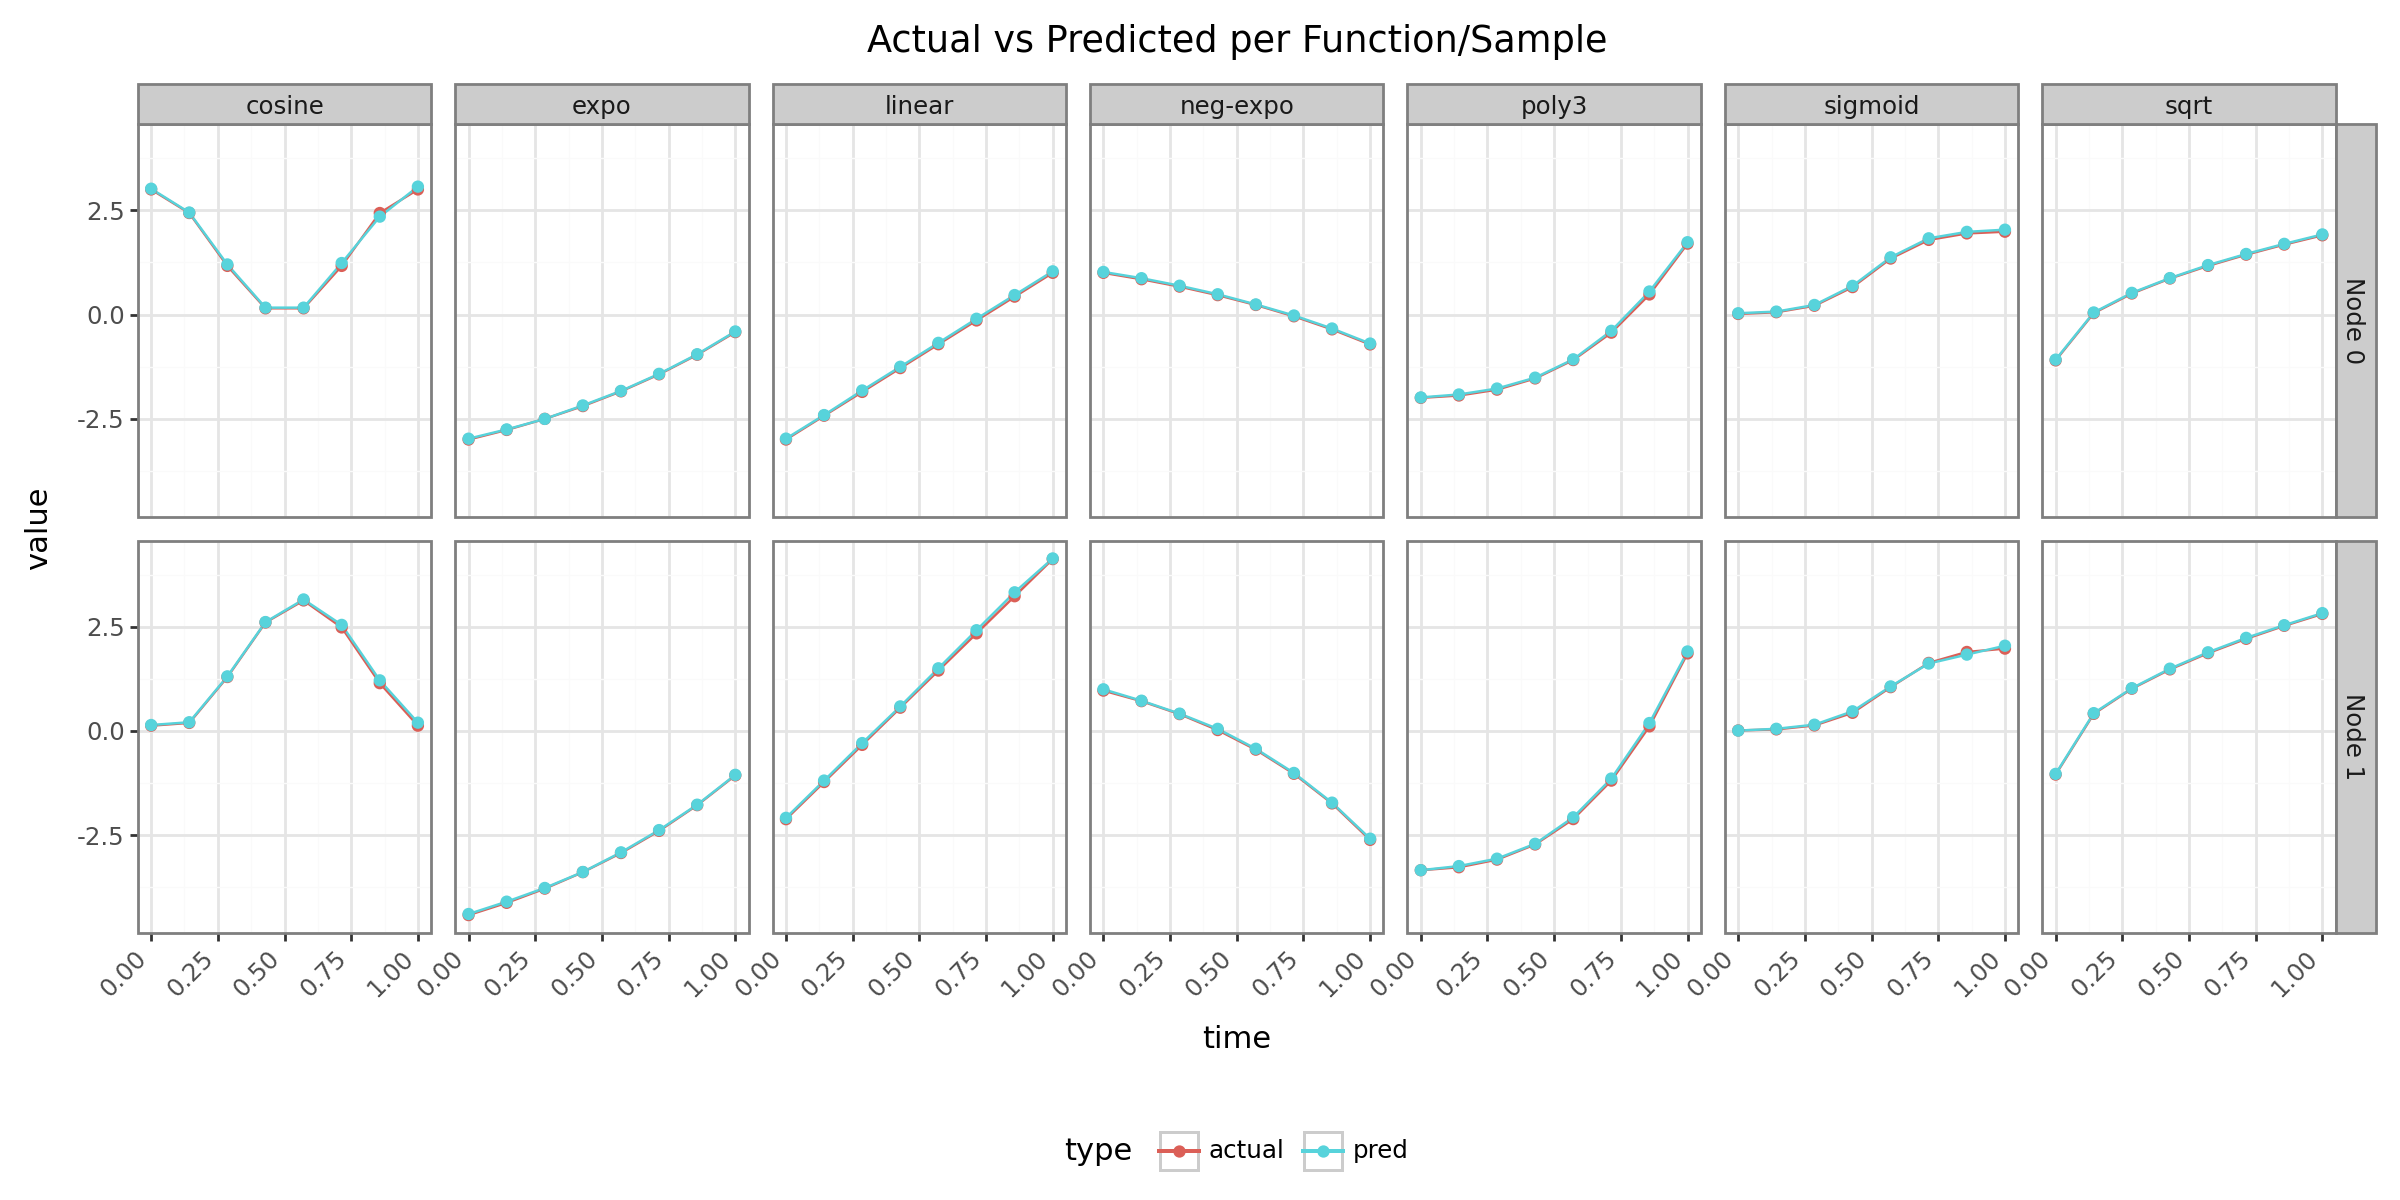

C:\Users\kanto\AppData\Local\Temp\ipykernel_29704\3870311747.py:192: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


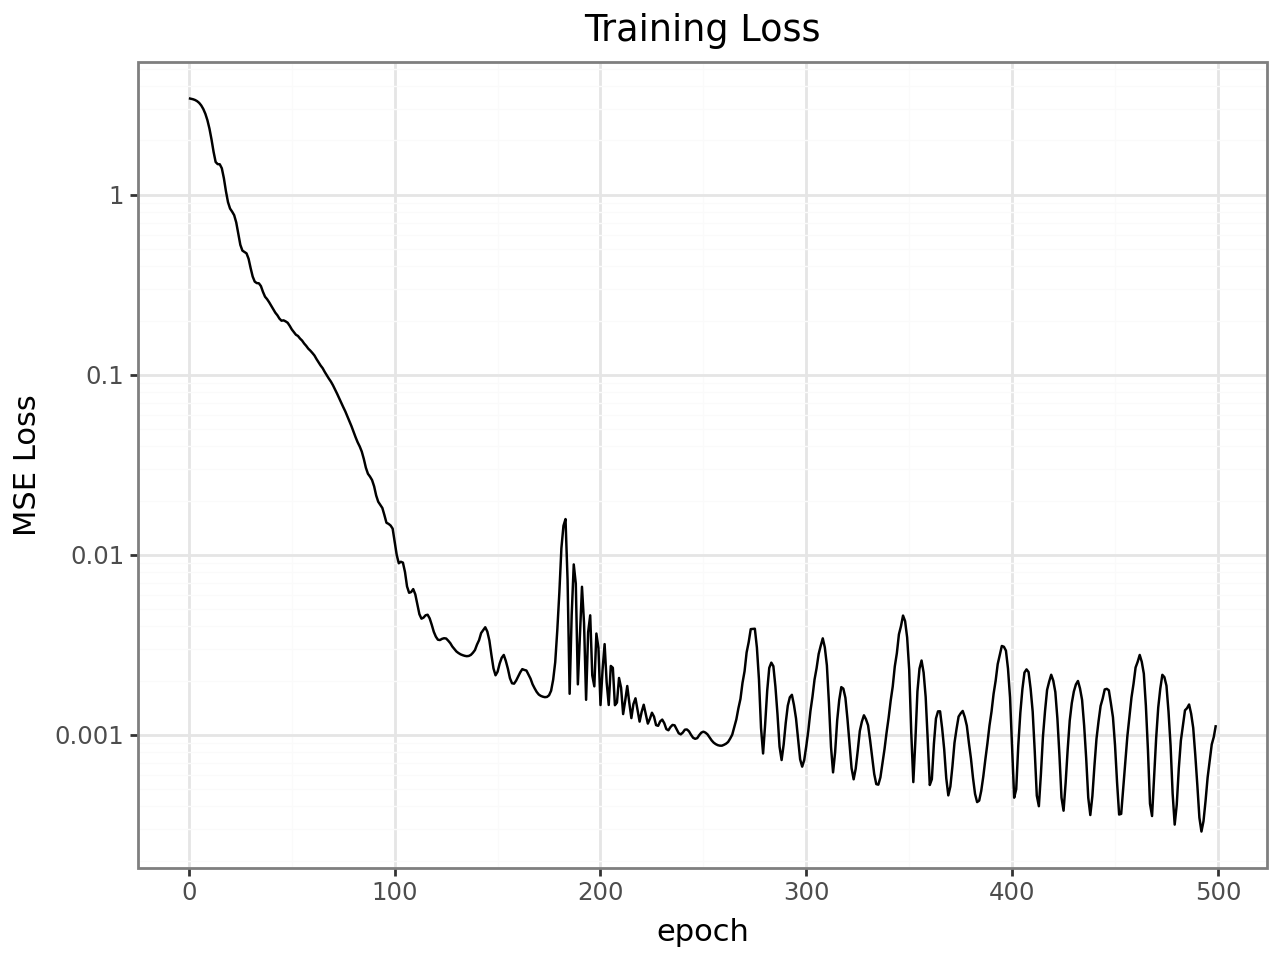

C:\Users\kanto\AppData\Local\Temp\ipykernel_29704\3870311747.py:193: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


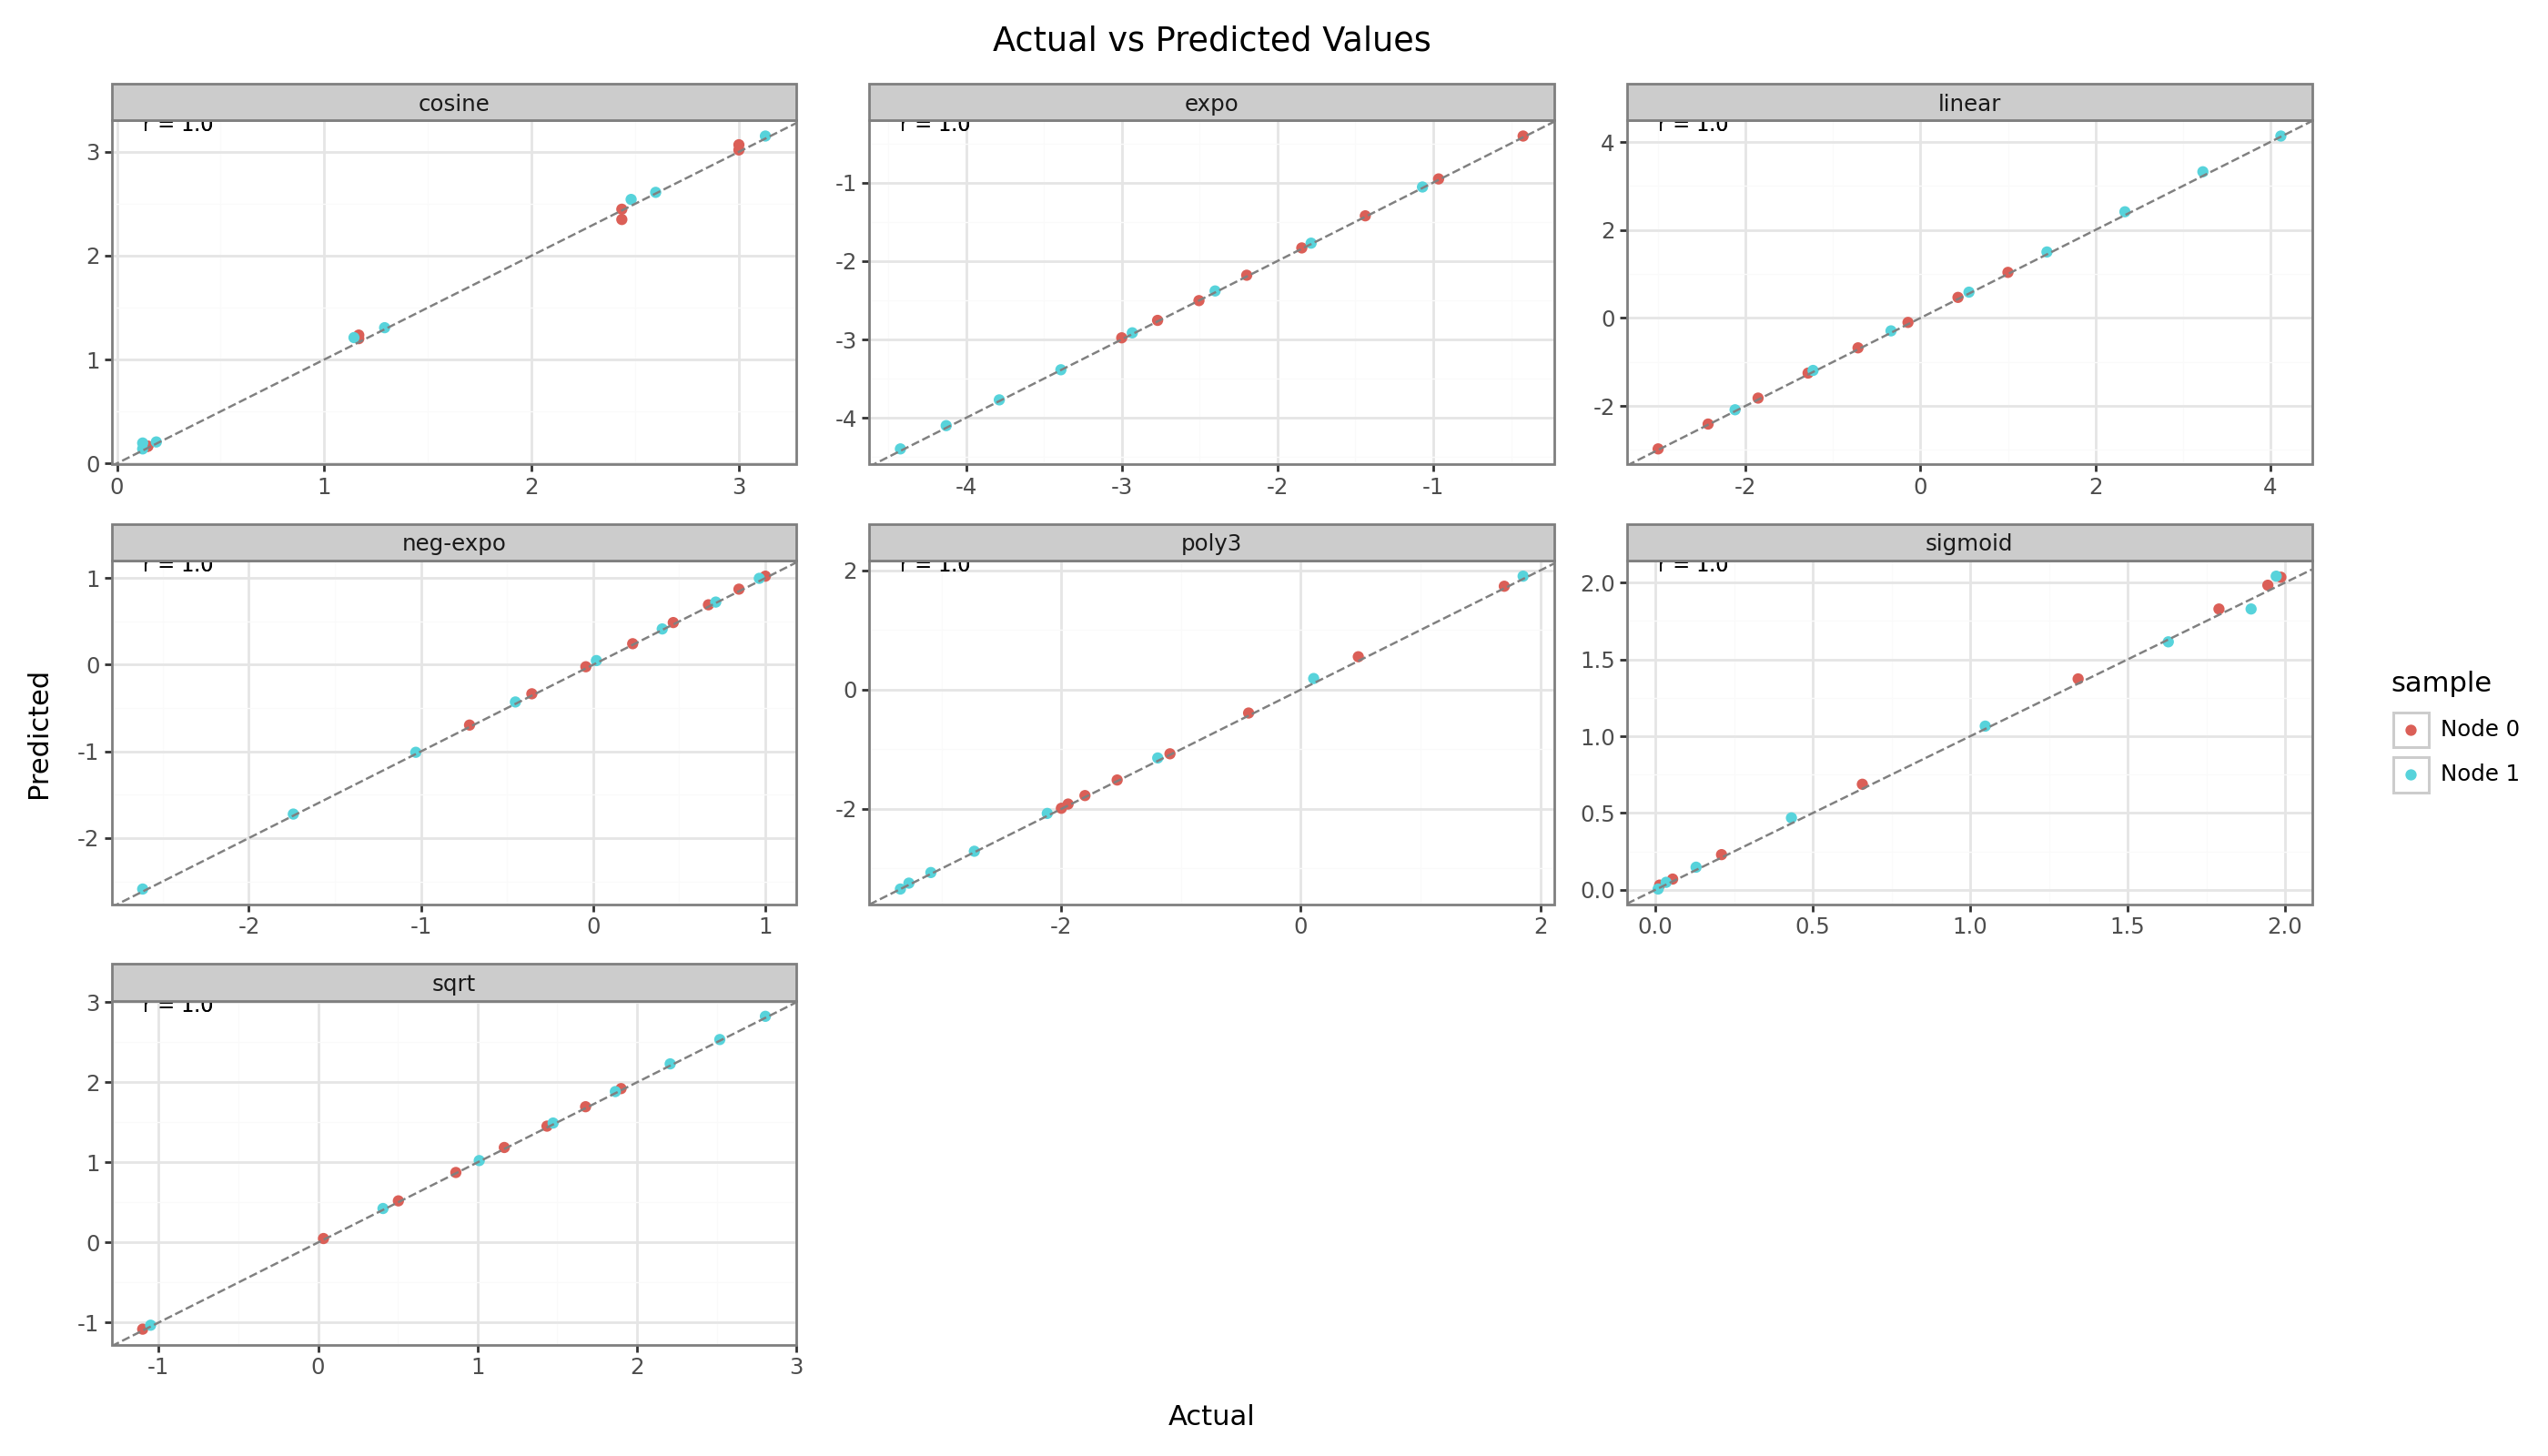

In [9]:
def run_unit_test():
    torch.manual_seed(0)
    np.random.seed(0)

    t = np.linspace(0, 1, 8)

    def poly3(t,a,b,c,d):  return a*t**3 + b*t**2 + c*t + d
    def linear(t,a,b):     return a*t + b
    def sqrtf(t,a,b):      return a*np.sqrt(t) + b
    def sigmoid(t,a,b):    return 2/(1+np.exp(-a*(t-b)))
    def cosine(t,amp,ph):  return amp*(np.cos(2*np.pi*(t+ph))+1)/2
    def expo(t,a,b,c):       return a*(np.exp(b*t)+c)

    func_list = [
        ("poly3",   poly3,  {"a":2.5,"b":1.0,"c":0.2,"d":-2.0}),
        ("linear",  linear, {"a":4,"b":-3}),
        ("sqrt",    sqrtf,  {"a":3.0,"b":-1.1}),
        ("sigmoid", sigmoid,{"a":10.0,"b":0.5}),
        ("cosine",  cosine, {"amp":3,"ph":1.0}),
        ("expo",    expo,   {"a":1.5,"b":1.0, "c":-3}),
        ("neg-expo",    expo,   {"a":-1.0,"b":1.0, "c":-2}),
    ]

    n_nodes = 2
    n_funcs = len(func_list)
    n_sites = n_nodes * n_funcs
    
    # Simulate Y_actual: shape (2,8,7)
    Y_actual_np = np.zeros((1, t.size, n_sites), float)
    for s, (name, func, base) in enumerate(func_list):
        # add 10% noise to base params for sample 1
        params0 = base
        params1 = {k: v*(1+0.3*np.random.randn()) for k,v in base.items()}
        Y_actual_np[0,:,2*s] = func(t, **params0)
        Y_actual_np[0,:,2*s+1] = func(t, **params1)
    Y_actual = torch.tensor(Y_actual_np, dtype=torch.float32)  # shape (2, 8, 14)
    
    # Build Y_full shape (2,8,2)
    Y_full = torch.tensor(t, dtype=torch.float32)
    Y_full = Y_full.view(1, -1, 1).expand(1, -1, n_nodes)  # shape (2, 8, 2)
    
    # Build nodes_sites_map: 14×2 DataFrame
    rows = [f"func_{f}_sample_{s}" for f in range(n_funcs) for s in range(n_nodes)]
    cols = [f"node_{i}" for i in range(n_nodes)]
    nodes_sites_map = pd.DataFrame(0.0, index=rows, columns=cols)
    for f in range(n_funcs):
        for s in range(n_nodes):
            row = f"func_{f}_sample_{s}"
            nodes_sites_map.loc[row, f"node_{s}"] = 1.0
    
    # Train the embedding module
    model = NodesSitesMapping_embedding(nodes_sites_map, conn_dim=20, hidden_layers={1: 64, 2: 32, 3: 16})
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    n_epochs = 500
    loss_hist = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        Y_pred = model(Y_full)          # -> (2,8,14)
        loss = F.mse_loss(Y_pred, Y_actual)
        loss.backward()
        optimizer.step()
        loss_hist.append(float(loss))

    # Prepare data for plots
    traj_records = []
    Y_pred_np = Y_pred.detach().cpu().numpy()

    for s in range(2):
        for f in range(n_funcs):
            idx = f * 2 + s  # because the data alternates: func0_s0, func0_s1, func1_s0, ...
            func_name = func_list[f][0]
            for i, tt in enumerate(t):
                traj_records.append({
                    "sample": f"Node {s}",
                    "function": func_name,
                    "time": tt,
                    "value": Y_actual_np[0, i, idx],
                    "type": "actual"
                })
                traj_records.append({
                    "sample": f"Node {s}",
                    "function": func_name,
                    "time": tt,
                    "value": Y_pred_np[0, i, idx],
                    "type": "pred"
                })
    traj_df = pd.DataFrame(traj_records)

    p1 = (
      p9.ggplot(traj_df, p9.aes("time","value", color="type"))
      + p9.geom_line()
      + p9.geom_point()
      + p9.facet_grid("sample~function")  # Changed to rotate facets (rows become columns)
      + p9.labs(title="Actual vs Predicted per Function/Sample")
      + p9.theme_bw()
      + p9.theme(figure_size=(12, 6),
                subplots_adjust={'wspace':0.2, 'hspace':0.4},
                axis_text_x=p9.element_text(rotation=45, hjust=1),
                legend_position='bottom'))  # Added legend at bottom

    plot_loss = pd.DataFrame({"epoch":list(range(n_epochs)),"loss":loss_hist})
    p2 = (
      p9.ggplot(plot_loss, p9.aes("epoch","loss"))
      + p9.geom_line()
      + p9.scale_y_log10()
      + p9.labs(title="Training Loss", y="MSE Loss")
      + p9.theme_bw()
    )

    corr_records = []
    # Calculate correlations between actual and predicted values for each function/node
    for s in range(2):
        for f in range(n_funcs):
            idx = f * 2 + s  # same index calculation as above
            func_name = func_list[f][0]
            
            # Get actual and predicted values for this function and node
            actual = Y_actual_np[0, :, idx]
            pred = Y_pred_np[0, :, idx]
            
            # Calculate Pearson correlation
            corr = np.corrcoef(actual, pred)[0, 1]
            
            # Store correlation data
            corr_records.append({
                "sample": f"Node {s}",
                "function": func_name,
                "correlation": corr
            })

    # Create DataFrame for correlation data
    corr_df = pd.DataFrame(corr_records)

    # Create scatter plot data
    scatter_records = []
    for s in range(2):
        for f in range(n_funcs):
            idx = f * 2 + s
            func_name = func_list[f][0]
            
            # Get actual and predicted values
            actual = Y_actual_np[0, :, idx]
            pred = Y_pred_np[0, :, idx]
            
            # Add to scatter records
            for i in range(len(t)):
                scatter_records.append({
                    "sample": f"Node {s}",
                    "function": func_name,
                    "actual": actual[i],
                    "predicted": pred[i]
                })

    scatter_df = pd.DataFrame(scatter_records)

    # Add correlation text to the scatter data for annotation
    corr_text = corr_df.copy()
    corr_text['label'] = 'r = ' + corr_text['correlation'].round(2).astype(str)

    # Create correlation plot
    limits = (
        scatter_df.groupby("function")[["actual", "predicted"]]
        .agg({"actual": "min", "predicted": "max"})
        .rename(columns={"actual": "x_min", "predicted": "y_max"})
        .reset_index()
    )

    # 2. Merge with correlation labels
    corr_text = corr_text.merge(limits, on="function", how="left")

    # 3. Use the computed positions in geom_text
    p3 = (
        p9.ggplot(scatter_df, p9.aes('actual', 'predicted', color='sample'))
        + p9.geom_point()
        + p9.geom_abline(intercept=0, slope=1, linetype='dashed', color='gray')
        + p9.geom_text(
            p9.aes(x='x_min', y='y_max', label='label'),
            data=corr_text,
            inherit_aes=False,
            color='black',
            size=8,
            ha='left',
            va='bottom'  # bottom to push it slightly above the axis
        )
        + p9.facet_wrap('~function', scales='free')
        + p9.labs(title='Actual vs Predicted Values', x='Actual', y='Predicted')
        + p9.theme_bw()
        + p9.theme(figure_size=(14, 8))
    )
    
    print(p1)
    print(p2)
    print(p3)

if __name__=="__main__":
    run_unit_test()
